<a href="https://colab.research.google.com/github/lenderlucas/EACD-01-FUNDAMENTOS/blob/master/21%20-%20%5BTALLER%5D%20-%20Analisis%20exploratorio%20de%20un%20dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-01-FUNDAMENTOS/master/init.py
import init; init.init(force_download=False); 

replicating local resources


# Precios de Casas

El objetivo de este taller es realizar un análisis exploratorio de un dataset. El dataset no llega limpio, el proceso de limpieza se encuentra implementado. Después de este proceso de limpieza se debe llevar a cabo el análisis exploratorio.

In [3]:
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Entendiendo y limpiando el dataset

La descripcion de cada variable puede verse ejecutando la siguiente celda

In [4]:
!cat local/data/houseprices_description.txt

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

Ahora carguemos los datos y hagamos una breve exploración

In [5]:
df = pd.read_csv("local/data/houseprices.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Podemos ver que hay una gran cantidad de valores nulos en algunas de las variables. Alguien, algo despistado, podría sugerir simplemente eliminar esas variables; sin embargo, la descripción de las variables que observamos anteriormente, nos permite entender la razón de ser de estos valores nulos y tratarlos de una manera inteligente. Por ejemplo, consideremos la variable `PoolQC` la cual nos muestra únicamente 7 valores no nulos de los 1460 registros que tenemos en total. Su descripción dice:

```
PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

```

Esta variable hace referencia a la calidad de la piscina en la casa y vemos que `NA` significa que no tiene piscina, lo cual posiblemente tiene mucho impacto en el precio de una casa (pregúntese, ¿estaría dispuesto a pagar más por una casa que tenga piscina?). Además, vemos que existe la variable `PoolArea`, la cual almacena el area de la piscina en $ft^2$, la cual no tiene valores nulos. Dado esto, los valores nulos de la variable `PoolQC` deben corresponder a casos en los que la variable `PoolArea` es cero; validemos esto.

In [7]:
num_total_nulls = df["PoolQC"].isna().sum()
print(num_total_nulls)
num_nulls_when_poolarea_is_zero = df[df["PoolArea"] == 0]["PoolQC"].isna().sum()
print(num_nulls_when_poolarea_is_zero)
assert num_nulls_when_poolarea_is_zero == num_total_nulls

1453
1453


In [8]:
num_nulls_when_poolarea_is_not_zero = df[df["PoolArea"] != 0]["PoolQC"].isna().sum()
assert num_nulls_when_poolarea_is_not_zero == 0

Concluimos que se cumple que todos los valores nulos de la variable `PoolQC` corresponden a casos en los que no hay piscina; por lo tanto, vamos a reemplzar los valores nulos por otro valor que podamos usar en nuestros modelos.

In [9]:
df["PoolQC"] = df["PoolQC"].fillna("NP")

Esta misma lógica debemos usarla a la hora de tratar el resto de las variables con valores nulos de este dataset. Escribiremos algún razonamiento addiconal únicamente cuando haga falta

In [10]:
num_total_nulls = df["MiscFeature"].isna().sum()
num_nulls_when_miscval_is_zero = df[df["MiscVal"] == 0]["MiscFeature"].isna().sum()
num_nulls_when_miscval_is_not_zero = df[df["MiscVal"] != 0]["MiscFeature"].isna().sum()
assert num_nulls_when_miscval_is_zero == num_total_nulls
assert num_nulls_when_miscval_is_not_zero == 0
df["MiscFeature"] = df["MiscFeature"].fillna("No MF")

In [11]:
num_total_nulls = df["FireplaceQu"].isna().sum()
num_nulls_when_fireplaces_is_zero = df[df["Fireplaces"] == 0]["FireplaceQu"].isna().sum()
num_nulls_when_fireplaces_is_not_zero = df[df["Fireplaces"] != 0]["FireplaceQu"].isna().sum()
assert num_nulls_when_fireplaces_is_zero == num_total_nulls
assert num_nulls_when_fireplaces_is_not_zero == 0
df["FireplaceQu"] = df["FireplaceQu"].fillna("No FP")

In [12]:
num_area_zeros = (df["GarageArea"] == 0).sum()
num_cars_zeros = (df["GarageCars"] == 0).sum()
num_both_zeros = ((df["GarageArea"] == 0) & (df["GarageCars"] == 0.0)).sum()
assert num_both_zeros == num_area_zeros == num_cars_zeros
for colname in ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]:
    num_total_nulls = df[colname].isna().sum()
    num_nulls_when_area_and_cars_capacity_is_zero = df[(df["GarageArea"] == 0.0) & (df["GarageCars"] == 0.0)][colname].isna().sum()
    num_nulls_when_area_and_cars_capacity_is_not_zero = df[(df["GarageArea"] != 0.0) & (df["GarageCars"] != 0.0)][colname].isna().sum()
    assert num_total_nulls == num_nulls_when_area_and_cars_capacity_is_zero
    assert num_nulls_when_area_and_cars_capacity_is_not_zero == 0
    df[colname] = df[colname].fillna("No Ga")

Para la variable `GarageYrBlt` debemos ser más cuidadosos, ya que son números y no strings. Esta variable nos dice el año en que fue construido el garaje y, según lo visto con otras variables relacionadas al garage, los valores nulos corresponden a casos en los que no hay garage. En este caso, vamos a imputar esa variable con un año posterior a la fecha de venta. Esta aproximación podría no funcionar muy bien con modelos lineales, o cuando escalamos los datos, pero no se me ocurre otra!

In [13]:
num_total_nulls = df["GarageYrBlt"].isna().sum()
num_nulls_when_area_and_cars_is_zero = df[(df["GarageArea"] == 0.0) & (df["GarageCars"] == 0.0)]["GarageYrBlt"].isna().sum()
num_nulls_when_area_and_cars_is_not_zero = df[(df["GarageArea"] != 0.0) & (df["GarageCars"] != 0.0)]["GarageYrBlt"].isna().sum()
assert num_nulls_when_area_and_cars_is_zero == num_total_nulls
assert num_nulls_when_area_and_cars_is_not_zero == 0
df["GarageYrBlt"].where(~df["GarageYrBlt"].isna(), other=df["YrSold"] + 1, inplace=True)

`LotFrontage: Linear feet of street connected to property)`

Valores nulos en esta variable podrían ser ocasionados porque sencillamente no hay conexión de la calle a la propiedad, es decir, que esa longitud medida por esta variable es igual a 0. Podemos asumir que este es el caso únicamente si no hay otro 0 en los valores que ha tomado esta variable, de otra manera ¿por qué algunos tendrían 0 y otros nulos?

In [14]:
assert (df["LotFrontage"] == 0).sum() == 0
df["LotFrontage"].fillna(0, inplace=True)

In [15]:
df["Alley"].fillna("NA", inplace=True)
df["Fence"].fillna("NF", inplace=True)

```
MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone
	
MasVnrArea: Masonry veneer area in square feet
```

Una posibilidad es que los valores nulos de `MasVnrType` y `MasVnrArea` correspondan a casos en los que no hay "Masonry veneer" (chapa de albañilería). Esto sería en los casos en que la variable `MasVnrArea` sea 0, esto lo validaremos de la misma manera en que validamos con la variable `LotFrontage`.

In [16]:
assert (df["MasVnrArea"] == 0).sum() == df["MasVnrType"].isnull().sum()

AssertionError: ignored

Acá la situación es diferente, el error anterior nos dice que los casos para los cuales no tenemos área son distintos de los que el tipo es nulo, entonces nos toca inspeccionar más en detalle. Sabemos que hay 8 valores nulos en cada una de las dos variables, miremos si corresponden a los mismos registros:

In [17]:
np.logical_and(df["MasVnrType"].isnull().values, df["MasVnrArea"].isnull().values).sum()

8

En efecto, dado que hay 8 registros para los cuales las dos variables tienen valores nulos, podemos decir que son nulos en ambas partes. A falta de información, vamos a decidir eliminar esos registros por completo, no debe ser muy grave, pues apenas son 8 filas en todo el dataset.

In [18]:
df = df.dropna(subset=["MasVnrType", "MasVnrArea"])

Ahora miremos los valores de cada una

In [19]:
df["MasVnrType"].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [20]:
df["MasVnrArea"].value_counts()

0.0      861
180.0      8
72.0       8
108.0      8
120.0      7
        ... 
562.0      1
89.0       1
921.0      1
762.0      1
119.0      1
Name: MasVnrArea, Length: 327, dtype: int64

Acá podemos observar lo siguiente:
- Hay 864 registros con `MasVnrType="None"`
- Hay 861 registros con `MasVnrArea=0`

Eso quiere decir que hay algunos registros que deberían tener un área de 0 y no es así. Vamos a mirar en detalle cuáles son:

In [21]:
df[(df["MasVnrType"] == "None") & (df["MasVnrArea"] != 0.0)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
624,625,60,RL,80.0,10400,Pave,NA,Reg,Lvl,AllPub,...,0,NP,NF,No MF,0,11,2006,WD,Normal,165150
773,774,20,RL,70.0,10150,Pave,NA,Reg,Lvl,AllPub,...,0,NP,NF,No MF,0,7,2007,COD,Normal,114500
1230,1231,90,RL,0.0,18890,Pave,NA,IR1,Lvl,AllPub,...,0,NP,NF,Gar2,8300,8,2007,WD,Normal,190000
1300,1301,60,RL,0.0,10762,Pave,NA,IR1,Lvl,AllPub,...,0,NP,NF,No MF,0,5,2009,WD,Normal,225000
1334,1335,160,RM,24.0,2368,Pave,NA,Reg,Lvl,AllPub,...,0,NP,NF,No MF,0,5,2009,WD,Normal,125000


**Francamente** yo no soy un experto en casas, por lo que no tengo forma de deducir a qué se debe esa incoherencia en los datos. Por lo anterior, simplemente voy a eliminar esas filas, ya que tengo dudas de la veracidad de esos datos.

In [22]:
df = df[~((df["MasVnrType"] == "None") & (df["MasVnrArea"] != 0.0))]

La variable `Electrical` tampoco nos ofrece una forma de recuperar esos valores nulos, por lo que también vamos a eliminar ese registro. Nótese que otra opción podría ser reemplazarlo con el valor más común en la misma variable, dado que esta es categórica. 

In [23]:
df.dropna(subset=["Electrical"], inplace=True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1446 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1446 non-null   int64  
 1   MSSubClass     1446 non-null   int64  
 2   MSZoning       1446 non-null   object 
 3   LotFrontage    1446 non-null   float64
 4   LotArea        1446 non-null   int64  
 5   Street         1446 non-null   object 
 6   Alley          1446 non-null   object 
 7   LotShape       1446 non-null   object 
 8   LandContour    1446 non-null   object 
 9   Utilities      1446 non-null   object 
 10  LotConfig      1446 non-null   object 
 11  LandSlope      1446 non-null   object 
 12  Neighborhood   1446 non-null   object 
 13  Condition1     1446 non-null   object 
 14  Condition2     1446 non-null   object 
 15  BldgType       1446 non-null   object 
 16  HouseStyle     1446 non-null   object 
 17  OverallQual    1446 non-null   int64  
 18  OverallC

Ahora miremos las variables relacionadas con el basement:

```

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

```

Dado que los valores nulos en varias de estas variables corresponden a `No Basement`, ahora miremos si los registros nulos en algunas corresponden a los registros nulos en todas. Primero, dado que ya hemos eliminado varios registros, vamos a ver cuántos valores nulos hay en esas variables.

In [25]:
colnames = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
    "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"]
for c in colnames:
    print(f"{c} has {df[c].isnull().sum()} null values")

BsmtQual has 37 null values
BsmtCond has 37 null values
BsmtExposure has 38 null values
BsmtFinType1 has 37 null values
BsmtFinSF1 has 0 null values
BsmtFinType2 has 38 null values
BsmtFinSF2 has 0 null values
BsmtUnfSF has 0 null values
TotalBsmtSF has 0 null values


In [26]:
df["TotalBsmtSF"].value_counts()

0       37
864     35
672     17
912     14
1040    14
        ..
1581     1
707      1
611      1
1452     1
1542     1
Name: TotalBsmtSF, Length: 716, dtype: int64

Acá vemos que algunas tienen más variables nulas que otras, lo cual es confuso porque en cualquier caso los valores nulos deberían significar que no hay basement. En este caso vamos a reemplazar los valores en los que los valores nulos sean en todas las variables no numéricas pero los que sobren los eliminaremos.

In [27]:
colnames = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]
cond = ~(df["BsmtQual"].isna() & df["BsmtCond"].isna() & df["BsmtExposure"].isna() & df["BsmtFinType1"].isna() & df["BsmtFinType2"].isna())
for c in colnames:
    df[c].where(cond, other="NB", inplace=True)

In [28]:
df.dropna(inplace=True)
print(f"Number of null values {df.isna().sum().sum()} in a dataframe of shape {df.shape}")

Number of null values 0 in a dataframe of shape (1444, 81)


## Análisis exploratorio de datos

En esta sección se dejarán preguntas que deben ser respondidas utilizando los datos.

**¿Qué tan viejas son las casas?**

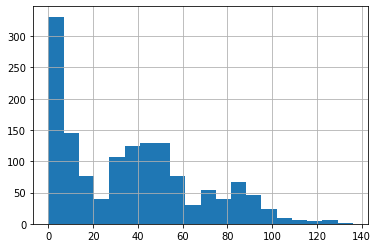

In [29]:
df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
df["HouseAge"].hist(bins=20)

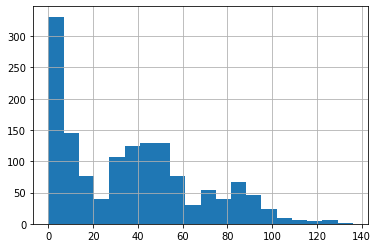

In [31]:
df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
df["HouseAge"].hist(bins=20)

**¿Cuál es el barrio más pobre?**

              OverallQual  OverallCond  YearRemodAdd   HouseAge  \
Neighborhood                                                      
Blmngtn          7.176471     5.000000   2005.764706   2.235294   
Blueste          6.000000     6.000000   1980.000000  28.500000   
BrDale           5.733333     5.400000   1973.866667  36.066667   
BrkSide          5.051724     6.137931   1968.586207  76.241379   
ClearCr          5.892857     5.678571   1983.750000  41.214286   
CollgCr          6.628378     5.243243   1999.101351   9.986486   
Crawfor          6.280000     6.660000   1979.280000  66.260000   
Edwards          5.080000     5.440000   1975.110000  51.970000   
Gilbert          6.558442     5.129870   1998.779221   9.311688   
IDOTRR           4.756757     5.540541   1964.378378  79.810811   
MeadowV          4.470588     5.529412   1976.705882  35.470588   
Mitchel          5.591837     5.367347   1985.551020  26.000000   
NAmes            5.361607     5.794643   1971.683036  47.86607

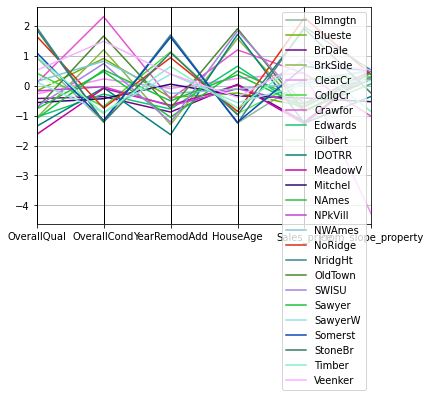

In [30]:
df.groupby("Neighborhood").mean()["OverallQual"]

Comparacion_pobreza = df.groupby("Neighborhood").mean()["OverallQual"]

Comparacion_pobreza =  pd.DataFrame(Comparacion_pobreza)

Comparacion_pobreza["OverallCond"] = df.groupby("Neighborhood").mean()["OverallCond"]

Comparacion_pobreza["YearRemodAdd"] = df.groupby("Neighborhood").mean()["YearRemodAdd"]

Comparacion_pobreza["HouseAge"] = df.groupby("Neighborhood").mean()["HouseAge"]

Comparacion_pobreza["Sales_price"] = df.groupby("Neighborhood").mean()["SalePrice"]
       
df["Prom_slope_property"] = df.LandSlope.replace({"Gtl": 3, "Mod": 2, "Sev": 1})

Comparacion_pobreza["Prom_slope_property"] = df.groupby("Neighborhood").mean()["Prom_slope_property"]

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates
 

def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

Comparacion_pobreza_normalizada = mean_norm(Comparacion_pobreza)


Comparacion_pobreza_normalizada['Neighborhood'] = Comparacion_pobreza_normalizada.index

print(Comparacion_pobreza)
# Make the plot
parallel_coordinates(Comparacion_pobreza_normalizada, 'Neighborhood')
plt.show()

El barrio mas pobre es Meadow Village debido a que la calidad de construccion de sus casas es la mas baja de todas, ademas tambien es el barrio con mayor inclinacion, lo cual es una desventaja frente a barrios que se ubican en superficies planas. Tambien se debe mencionar que ocupa la posicion 11 de los barrios mas antiguos de un total de 26 barrios, ademas de ser el barrio con menor valor promedio de venta de sus casas, por tanto es uno de los barrios con mayor pobreza.

**¿Cuál es el barrio más cercano a vías férreas?**

In [32]:
Proporcion_vias_ferreas = df[df.Condition1.isin(['RRNn','RRAn','RRNe','RRAe'])]
Proporcion_vias_ferreas = pd.crosstab(index=Proporcion_vias_ferreas['Condition1'], columns=Proporcion_vias_ferreas["Neighborhood"],
                                        margins=True).apply(lambda r: r/len(Proporcion_vias_ferreas)*100,axis=1)
Proporcion_vias_ferreas

Neighborhood,BrkSide,Gilbert,IDOTRR,NWAmes,OldTown,Sawyer,SawyerW,Somerst,All
Condition1,,,,,,,,,
RRAe,0.000000,0.000000,2.272727,0.000000,0.000000,13.636364,9.090909,0.000000,25.000000
RRAn,15.909091,18.181818,0.000000,13.636364,2.272727,0.000000,0.000000,9.090909,59.090909
RRNe,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.545455,0.000000,4.545455
RRNn,2.272727,2.272727,2.272727,0.000000,0.000000,0.000000,0.000000,4.545455,11.363636
All,18.181818,20.454545,4.545455,13.636364,2.272727,13.636364,13.636364,13.636364,100.000000


Se crea una tabla que nos muestra la proporcion de vias tipo ferreas por cada barrio, y se nota gran superiodad de los barrios Gilbert y Brkside, ya que cuentan con 20.45% y 18.18% respectivamente del total de de vias ferreas. Por tanto concluimos que estos barrios estan cercanos a tener el 40% de vias ferreas totales.

**¿Cuál es la cobertura más común en las casas que se encuentran el el top 10% en precio?**

In [33]:
Valores_mas_altos = df['SalePrice'].nlargest(n = round(len(df)*0.10))
Valores_mas_altos

691     755000
1182    745000
1169    625000
898     611657
803     582933
         ...  
408     280000
451     280000
1109    280000
13      279500
1044    278000
Name: SalePrice, Length: 144, dtype: int64

**¿En qué barrio hay mayor desigualdad?**

Existen muchos tipos de desigualdad, para este ejemplo miraremos la desigualdad en terminos economicos y de condiciones de la vivienda, por tanto analizaremos la distribucion de las variables de "Precio de venta" y "Condiciones de la vivienda"

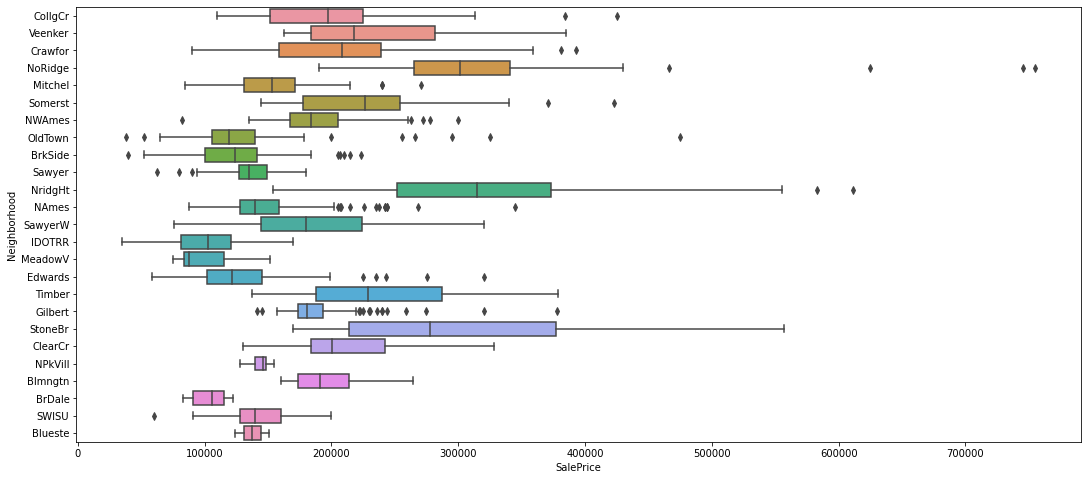

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize = (18,8))
sns.boxplot(y = df['Neighborhood'],
            x = df['SalePrice'])

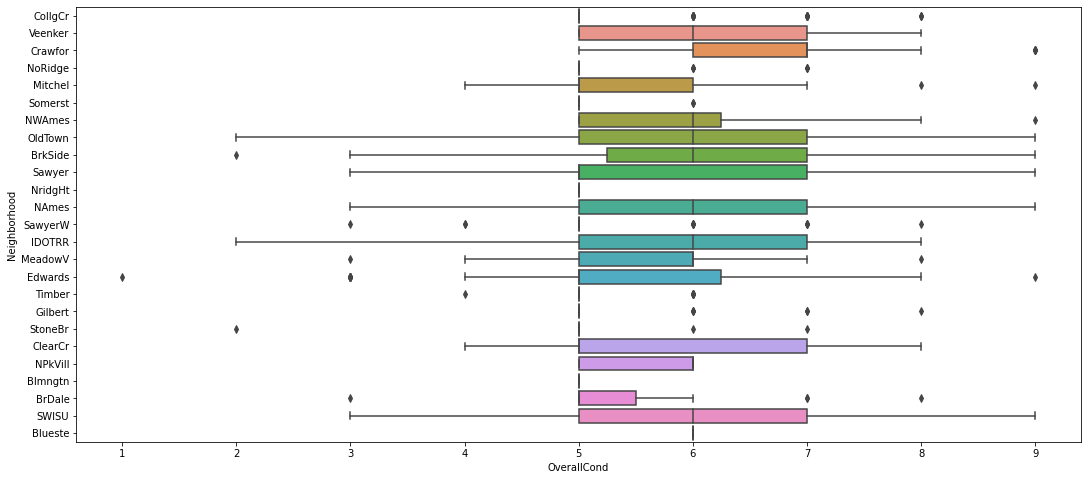

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize = (18,8))
sns.boxplot(y = df['Neighborhood'],
            x = df['OverallCond'])

Se concluye que el barrio con mayor desigualdad en la parte economica y de condiciones de vivienda es OldTown, pues la distribucion de ambos box plots es la mas dispersa, pues tiene rangos demasiados amplios y se observan valores atipicos, por lo cual tiene una distribucion no normal y con la que concluimos que su densidad es baja y por tanto desigual.

**¿En qué año hubo más movimiento del mercado inmobiliario?**

In [ ]:
mercado_inmobiliario = df.groupby("YrSold").size()

mercado_inmobiliario =  pd.DataFrame(mercado_inmobiliario)

YearRemodAdd_= df[df['YearRemodAdd'] >= 2006]

mercado_inmobiliario["Remodelacion"] = YearRemodAdd_.groupby("YearRemodAdd").size()


mercado_inmobiliario = mercado_inmobiliario.rename(columns={0:'Ventas'})

mercado_inmobiliario["Movimiento_mercado"] = mercado_inmobiliario.Ventas + mercado_inmobiliario.Remodelacion

df["YrSold"].hist(bins=40)

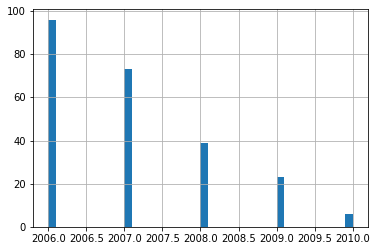

In [38]:
YearRemodAdd_["YearRemodAdd"].hist(bins=40)

In [39]:
print(mercado_inmobiliario)

        Ventas  Remodelacion  Movimiento_mercado
YrSold                                          
2006       311            96                 407
2007       325            73                 398
2008       300            39                 339
2009       334            23                 357
2010       174             6                 180


El año con mas movimiento inmobiliario fue el 2006 ya que en su totalidad hubo 407 movimientos, de los cuales 311 fueron ventas y 96 fueron remodelaciones de vivienda

**¿Cuáles son los 2 barrios con mayor industria cerca?**

In [40]:
df.groupby("MSZoning").size()

MSZoning
C (all)      10
FV           62
RH           16
RL         1139
RM          217
dtype: int64

Como podemos observar en la tabla anterior no tenemos informacion acerca de barrios que se encuentren en areas industriales, por tanto ningun barrio tiene mayor industria cerca, pues estan localizadosen zonas no industriales segun el dataframe analizado

**¿Cuáles son los 2 barrios con mayor comercio cerca?**

In [41]:
Zona_mayor_densidad = df[df.MSZoning.str.contains('RH|RM')]
Zona_mayor_densidad = pd.crosstab(index=Zona_mayor_densidad['MSZoning'], columns=Zona_mayor_densidad["Neighborhood"],
                                        margins=True).apply(lambda r: r/len(Zona_mayor_densidad)*100,axis=1)
Zona_mayor_densidad

Neighborhood,Blmngtn,Blueste,BrDale,BrkSide,CollgCr,Crawfor,Edwards,IDOTRR,MeadowV,Mitchel,NAmes,NridgHt,OldTown,SWISU,Sawyer,SawyerW,All
MSZoning,,,,,,,,,,,,,,,,,
RH,0.000000,0.000000,0.000000,0.000000,0.000000,0.858369,0.858369,0.000000,0.000000,0.000000,0.858369,0.000000,0.000000,2.145923,0.000000,2.145923,6.866953
RM,0.429185,0.858369,6.437768,12.875536,4.291845,1.287554,3.433476,12.017167,7.296137,2.145923,0.000000,0.429185,40.772532,0.000000,0.858369,0.000000,93.133047
All,0.429185,0.858369,6.437768,12.875536,4.291845,2.145923,4.291845,12.017167,7.296137,2.145923,0.858369,0.429185,40.772532,2.145923,0.858369,2.145923,100.000000


Para resolver este ejercicio se plantea el siguiente supuesto, a mayor densidad poblacional de un barrio mayor comercio necesitara para abastecer todas sus demandas. Por tanto el barrio con mayor comercio cerca sera el de mayor proporcion de zonas densamente pobladas. Por consiguiente los dos barrios con mayor comercio son OldTown y BrkSide.